# About this notebook
- tokenizer(anchor[SEP]target | CPC)
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
comp_name = 'us-patent-phrase-to-phrase-matching'
nb_name = 'nb005t-deberta-v3-large'

import sys
print(sys.version)
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    base = f"/content/drive/MyDrive/colab_notebooks/kaggle/{comp_name}/notebooks"
    %cd {base}


import os
INPUT_DIR = f'../input/{comp_name}/'
if 'kaggle_web_client' in sys.modules:
    OUTPUT_DIR = './'
else:
    OUTPUT_DIR = f'../input/{nb_name}/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Mounted at /content/drive
/content/drive/MyDrive/colab_notebooks/kaggle/us-patent-phrase-to-phrase-matching/notebooks


# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    wandb=True
    wandbproject=comp_name
    wandbgroup=nb_name
    wandbname='exp003.001'
    _wandb_kernel='riow1983'
    apex=True
    print_freq=100
    num_workers=8
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    #### AWP
    adv_lr=1e-6
    adv_eps=1e-3
    #### AWPAWP
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    CFG.wandb = False

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    if 'google.colab' in sys.modules:
        !pip install wandb
    import wandb

    try:
        if 'kaggle_web_client' in sys.modules:
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
        else:
            import json
            f = open("../../wandb.json", "r")
            json_data = json.load(f)
            secret_value_0 = json_data["wandb_api"]
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))
    
    run = wandb.init(
        dir=OUTPUT_DIR,
        project=CFG.wandbproject,
        group=CFG.wandbgroup,
        name=CFG.wandbname, 
        config=class2dict(CFG),
        job_type="train",
        anonymous=anony)
    print(f"wandb run id: {run.id}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 14.0 MB/s 
     |████████████████████████████████| 181 kB 80.9 MB/s 
     |████████████████████████████████| 145 kB 58.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=663e81b023c9435082a69c461af13973871228817a8de06c90b6cda55ae69762
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: riow1983. Use `wandb login --relogin` to force relogin


wandb run id: 11cyazz2


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


# # PyTorchのバージョンを1.10.1に下げる (Google Colabなのでpipでやる)
# os.system('pip uninstall -y torch torchvision torchaudio')
# os.system('pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html')


import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
# os.system('python -m pip install transformers')
# os.system('python -m pip install tokenizers')
os.system('pip install sentencepiece')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
#### AUG
# train = pd.read_csv(INPUT_DIR+'train.csv')
train = pd.read_csv('../input/kagglenb006-back-translate-aug-data/train.csv')
#### AUGAUG
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (145477, 6)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,context,score,anchor,target,is_aug
0,37d61fd2272659b1,A47,0.50,abatement,abatement of pollution,0
1,7b9652b17b68b7a4,A47,0.75,abatement,act of abating,0
2,36d72442aefd8232,A47,0.25,abatement,active catalyst,0
3,5296b0c19e1ce60e,A47,0.50,abatement,eliminating process,0
4,54c1e3b9184cb5b6,A47,0.00,abatement,forest region,0


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,context,score,anchor,target,is_aug,context_text
0,37d61fd2272659b1,A47,0.50,abatement,abatement of pollution,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,A47,0.75,abatement,act of abating,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,A47,0.25,abatement,active catalyst,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,A47,0.50,abatement,eliminating process,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,A47,0.00,abatement,forest region,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
# train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
# test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']

train['text'] = train['anchor'] + '[SEP]' + train['target']
test['text'] = test['anchor'] + '[SEP]' + test['target']

train['text2'] = train['context_text']
test['text2'] = test['context_text']


display(train.head())
display(test.head())

,id,context,score,anchor,target,is_aug,context_text,text,text2
0,37d61fd2272659b1,A47,0.50,abatement,abatement of pollution,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,A47,0.75,abatement,act of abating,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,A47,0.25,abatement,active catalyst,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,A47,0.50,abatement,eliminating process,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,A47,0.00,abatement,forest region,0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text,text,text2
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural network,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

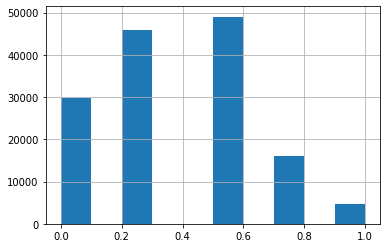

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    32056
H    24644
G    23870
C    21085
A    16372
F    16214
E     6122
D     5114
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())


#### AUG
aug = train[train['is_aug']==1].reset_index(drop=True)
train = train[train['is_aug']==0].reset_index(drop=True)
#### AUGAUG


# Credits to https://www.kaggle.com/code/hannes82/pppm-deberta-v3-large-closing-the-cv-lb-gap/notebook#CV-split
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
del dfx



#### AUG
res = []
for fold in range(CFG.n_fold):
    val_ids = train.loc[train['fold']==fold, 'id'].values
    to_add_aug = aug[~aug['id'].isin(val_ids)].reset_index(drop=True)
    to_add_aug['fold'] = fold+10
    res.append(to_add_aug)

to_add_aug = pd.concat(res, axis=0, ignore_index=True)
train = pd.concat([train, to_add_aug], axis=0, ignore_index=True)
del aug, to_add_aug, res, val_ids
#### AUGAUG

print(train.fold.value_counts())

550 183
549 184
550 183
550 183
12    83225
11    82626
10    81003
13    80158
3      9622
0      9379
1      8860
2      8612
Name: fold, dtype: int64


In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
# CFG.max_len = max(max(lengths_dict['anchor'])+max(lengths_dict['target'])+3, max(lengths_dict['context_text'])+2)
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/363485 [00:00<?, ?it/s]

  0%|          | 0/363485 [00:00<?, ?it/s]

max_len: 134


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text, text2):
    inputs = cfg.tokenizer(text, text2,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.texts2 = df['text2'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item], self.texts2[item])
        #inputs2 = prepare_input(self.cfg, self.texts2[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        #return inputs, inputs2, label
        return inputs, label

In [16]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [17]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        # outputs2 = self.model(**inputs2)
        # last_hidden_states2 = outputs2[0]
        
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        #feature2 = torch.mean(last_hidden_states2, dim=1)
        #feature += feature2
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

#### AWP
#def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp):
#### AWPAWP
    model.train()
    # AWP
    #scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    # AWPAWP
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0

    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        #### AWP
        if score > 0.75:
            awp.attack_backward(inputs['input_ids'], labels, inputs['attention_mask'], step) 
        #### AWPAWP

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs[1].items():
        #     inputs[1][k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [19]:
#### AWP
class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param="weight",
        adv_lr=1,
        adv_eps=0.2,
        start_epoch=0,
        adv_step=1,
        scaler=None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_epoch = start_epoch
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler

    def attack_backward(self, x, y, attention_mask,epoch):
        if (self.adv_lr == 0) or (epoch < self.start_epoch):
            return None

        self._save() 
        for i in range(self.adv_step):
            self._attack_step() 
            with torch.cuda.amp.autocast():
                adv_loss, tr_logits = self.model(input_ids=x, attention_mask=attention_mask, labels=y)
                adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                # param.data.clamp_(*self.backup_eps[name])

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}

#### AWPAWP

In [20]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    
    #### AUG
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    train_folds_aug = train_folds[train_folds['fold']==fold+10].reset_index(drop=True)
    train_folds_base = train_folds[train_folds['fold']<10].reset_index(drop=True)
    train_folds = pd.concat([train_folds_base, train_folds_aug], axis=0, ignore_index=True)
    del train_folds_aug, train_folds_base
    #### AUGAUG

    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    #### AWP
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    awp = AWP(model,
              optimizer,
              adv_lr=CFG.adv_lr,
              adv_eps=CFG.adv_eps,
              start_epoch=num_train_steps/CFG.epochs,
              scaler=scaler)
    score = 0.
    #### AWPAWP
    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        #### AWP
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp)
        #### AWPAWP

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()




    # Push to LINE
    import requests

    def send_line_notification(message):
        import json
        f = open("../../line.json", "r")
        json_data = json.load(f)
        line_token = json_data["kagglePush"]
        endpoint = 'https://notify-api.line.me/api/notify'
        message = "\n{}".format(message)
        payload = {'message': message}
        headers = {'Authorization': 'Bearer {}'.format(line_token)}
        requests.post(endpoint, data=payload, headers=headers)

    if CFG.wandb:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done. See {run.url}")
    else:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done.")

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/6756] Elapsed 0m 1s (remain 121m 1s) Loss: 0.6789(0.6789) Grad: inf  LR: 0.00002000  
Epoch: [1][100/6756] Elapsed 0m 28s (remain 31m 17s) Loss: 0.5467(0.6436) Grad: 126589.1328  LR: 0.00002000  
Epoch: [1][200/6756] Elapsed 0m 55s (remain 30m 12s) Loss: 0.5931(0.6191) Grad: 67985.2734  LR: 0.00002000  
Epoch: [1][300/6756] Elapsed 1m 22s (remain 29m 39s) Loss: 0.6187(0.6040) Grad: 93247.8438  LR: 0.00001999  
Epoch: [1][400/6756] Elapsed 1m 50s (remain 29m 11s) Loss: 0.5792(0.5986) Grad: 79098.7188  LR: 0.00001999  
Epoch: [1][500/6756] Elapsed 2m 17s (remain 28m 42s) Loss: 0.6123(0.5951) Grad: 66245.0391  LR: 0.00001998  
Epoch: [1][600/6756] Elapsed 2m 45s (remain 28m 14s) Loss: 0.6278(0.5895) Grad: 53881.5312  LR: 0.00001998  
Epoch: [1][700/6756] Elapsed 3m 13s (remain 27m 47s) Loss: 0.5770(0.5840) Grad: 184335.4688  LR: 0.00001997  
Epoch: [1][800/6756] Elapsed 3m 40s (remain 27m 19s) Loss: 0.5448(0.5805) Grad: 65083.6367  LR: 0.00001996  
Epoch: [1][900/6756] Elapse

Epoch 1 - avg_train_loss: 0.5459  avg_val_loss: 0.5510  time: 1944s
Epoch 1 - Score: 0.8115
Epoch 1 - Save Best Score: 0.8115 Model


EVAL: [586/587] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6690(0.5510) 
Epoch: [2][0/6756] Elapsed 0m 0s (remain 96m 17s) Loss: 0.4830(0.4830) Grad: 1187.8508  LR: 0.00001707  
Epoch: [2][100/6756] Elapsed 0m 28s (remain 31m 21s) Loss: 0.6445(0.5180) Grad: 12458.0439  LR: 0.00001699  
Epoch: [2][200/6756] Elapsed 0m 56s (remain 30m 31s) Loss: 0.4836(0.5192) Grad: 4370.6733  LR: 0.00001690  
Epoch: [2][300/6756] Elapsed 1m 23s (remain 29m 49s) Loss: 0.4749(0.5137) Grad: 1974.6586  LR: 0.00001682  
Epoch: [2][400/6756] Elapsed 1m 50s (remain 29m 13s) Loss: 0.4069(0.5118) Grad: 6934.2925  LR: 0.00001673  
Epoch: [2][500/6756] Elapsed 2m 17s (remain 28m 41s) Loss: 0.5057(0.5127) Grad: 8283.0879  LR: 0.00001665  
Epoch: [2][600/6756] Elapsed 2m 45s (remain 28m 10s) Loss: 0.5830(0.5133) Grad: 4490.0254  LR: 0.00001656  
Epoch: [2][700/6756] Elapsed 3m 12s (remain 27m 40s) Loss: 0.5466(0.5121) Grad: 5248.4644  LR: 0.00001647  
Epoch: [2][800/6756] Elapsed 3m 39s (remain 27m 11s) Loss: 0.5816(0.51

Epoch 2 - avg_train_loss: 0.5010  avg_val_loss: 0.5805  time: 1938s
Epoch 2 - Score: 0.8141
Epoch 2 - Save Best Score: 0.8141 Model


EVAL: [586/587] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6558(0.5805) 
Epoch: [3][0/6756] Elapsed 0m 0s (remain 90m 56s) Loss: 0.5649(0.5649) Grad: 18476.8340  LR: 0.00001000  
Epoch: [3][100/6756] Elapsed 0m 28s (remain 31m 16s) Loss: 0.5413(0.5023) Grad: 146870.8125  LR: 0.00000988  
Epoch: [3][200/6756] Elapsed 0m 56s (remain 30m 26s) Loss: 0.3674(0.4992) Grad: 17436.2988  LR: 0.00000977  
Epoch: [3][300/6756] Elapsed 1m 23s (remain 29m 45s) Loss: 0.5219(0.4973) Grad: 74445.8984  LR: 0.00000965  
Epoch: [3][400/6756] Elapsed 1m 50s (remain 29m 14s) Loss: 0.4642(0.4922) Grad: 14272.2715  LR: 0.00000953  
Epoch: [3][500/6756] Elapsed 2m 17s (remain 28m 41s) Loss: 0.4750(0.4899) Grad: 27263.6484  LR: 0.00000942  
Epoch: [3][600/6756] Elapsed 2m 45s (remain 28m 11s) Loss: 0.5428(0.4899) Grad: 8074.2881  LR: 0.00000930  
Epoch: [3][700/6756] Elapsed 3m 12s (remain 27m 42s) Loss: 0.4212(0.4893) Grad: 23976.2051  LR: 0.00000919  
Epoch: [3][800/6756] Elapsed 3m 39s (remain 27m 13s) Loss: 0.42

Epoch 3 - avg_train_loss: 0.4866  avg_val_loss: 0.5913  time: 1939s
Epoch 3 - Score: 0.8034


EVAL: [586/587] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6521(0.5913) 
Epoch: [4][0/6756] Elapsed 0m 0s (remain 91m 8s) Loss: 0.4207(0.4207) Grad: 26153.7871  LR: 0.00000293  
Epoch: [4][100/6756] Elapsed 0m 27s (remain 30m 44s) Loss: 0.4914(0.4852) Grad: 34236.7031  LR: 0.00000285  
Epoch: [4][200/6756] Elapsed 0m 55s (remain 29m 58s) Loss: 0.5164(0.4830) Grad: 24597.9062  LR: 0.00000277  
Epoch: [4][300/6756] Elapsed 1m 22s (remain 29m 26s) Loss: 0.4386(0.4847) Grad: 12458.6514  LR: 0.00000269  
Epoch: [4][400/6756] Elapsed 1m 49s (remain 28m 57s) Loss: 0.5331(0.4849) Grad: 6158.9897  LR: 0.00000261  
Epoch: [4][500/6756] Elapsed 2m 16s (remain 28m 29s) Loss: 0.4634(0.4830) Grad: 3514.6848  LR: 0.00000253  
Epoch: [4][600/6756] Elapsed 2m 44s (remain 28m 0s) Loss: 0.4559(0.4841) Grad: 7371.8784  LR: 0.00000245  
Epoch: [4][700/6756] Elapsed 3m 11s (remain 27m 33s) Loss: 0.4855(0.4844) Grad: 18028.6250  LR: 0.00000238  
Epoch: [4][800/6756] Elapsed 3m 38s (remain 27m 5s) Loss: 0.4563(0.4

Epoch 4 - avg_train_loss: 0.4826  avg_val_loss: 0.6026  time: 1936s
Epoch 4 - Score: 0.8016


EVAL: [586/587] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6503(0.6026) 


========== fold: 0 result ==========
Score: 0.8141
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/6889] Elapsed 0m 0s (remain 90m 25s) Loss: 0.7798(0.7798) Grad: inf  LR: 0.00002000  
Epoch: [1][100/6889] Elapsed 0m 28s (remain 31m 37s) Loss: 0.6050(0.6451) Grad: 49970.8984  LR: 0.00002000  
Epoch: [1][200/6889] Elapsed 0m 55s (remain 30m 49s) Loss: 0.4570(0.6251) Grad: 52414.3828  LR: 0.00002000  
Epoch: [1][300/6889] Elapsed 1m 23s (remain 30m 17s) Loss: 0.5811(0.6108) Grad: 32924.5195  LR: 0.00001999  
Epoch: [1][400/6889] Elapsed 1m 50s (remain 29m 46s) Loss: 0.5522(0.6031) Grad: 22805.1699  LR: 0.00001999  
Epoch: [1][500/6889] Elapsed 2m 17s (remain 29m 15s) Loss: 0.5027(0.5965) Grad: 28928.5605  LR: 0.00001998  
Epoch: [1][600/6889] Elapsed 2m 45s (remain 28m 47s) Loss: 0.5685(0.5910) Grad: 17711.7109  LR: 0.00001998  
Epoch: [1][700/6889] Elapsed 3m 12s (remain 28m 19s) Loss: 0.5036(0.5857) Grad: 53873.1953  LR: 0.00001997  
Epoch: [1][800/6889] Elapsed 3m 39s (remain 27m 50s) Loss: 0.5813(0.5850) Grad: 19286.4375  LR: 0.00001996  
Epoch: [1][900/6889] Elapsed 

Epoch 1 - avg_train_loss: 0.5399  avg_val_loss: 0.5804  time: 1977s
Epoch 1 - Score: 0.7963
Epoch 1 - Save Best Score: 0.7963 Model


EVAL: [553/554] Elapsed 1m 30s (remain 0m 0s) Loss: 0.5099(0.5804) 
Epoch: [2][0/6889] Elapsed 0m 0s (remain 94m 24s) Loss: 0.5750(0.5750) Grad: 42066.9102  LR: 0.00001707  
Epoch: [2][100/6889] Elapsed 0m 28s (remain 32m 3s) Loss: 0.5677(0.4988) Grad: 13768.2920  LR: 0.00001699  
Epoch: [2][200/6889] Elapsed 0m 56s (remain 31m 12s) Loss: 0.5371(0.4995) Grad: 11465.9980  LR: 0.00001691  
Epoch: [2][300/6889] Elapsed 1m 23s (remain 30m 29s) Loss: 0.4417(0.5047) Grad: 5026.2720  LR: 0.00001682  
Epoch: [2][400/6889] Elapsed 1m 51s (remain 29m 57s) Loss: 0.4671(0.5078) Grad: 29972.4688  LR: 0.00001674  
Epoch: [2][500/6889] Elapsed 2m 18s (remain 29m 24s) Loss: 0.4237(0.5074) Grad: 6667.8140  LR: 0.00001666  
Epoch: [2][600/6889] Elapsed 2m 45s (remain 28m 53s) Loss: 0.4593(0.5077) Grad: 13857.4072  LR: 0.00001657  
Epoch: [2][700/6889] Elapsed 3m 12s (remain 28m 23s) Loss: 0.6596(0.5076) Grad: 4085.9236  LR: 0.00001648  
Epoch: [2][800/6889] Elapsed 3m 40s (remain 27m 53s) Loss: 0.4053(0

Epoch 2 - avg_train_loss: 0.5015  avg_val_loss: 0.5976  time: 1976s
Epoch 2 - Score: 0.7962


EVAL: [553/554] Elapsed 1m 30s (remain 0m 0s) Loss: 0.4978(0.5976) 
Epoch: [3][0/6889] Elapsed 0m 0s (remain 93m 56s) Loss: 0.3855(0.3855) Grad: 2675.7124  LR: 0.00001000  
Epoch: [3][100/6889] Elapsed 0m 28s (remain 31m 39s) Loss: 0.5129(0.4870) Grad: 33107.4023  LR: 0.00000989  
Epoch: [3][200/6889] Elapsed 0m 55s (remain 30m 53s) Loss: 0.3830(0.4899) Grad: 3481.0498  LR: 0.00000977  
Epoch: [3][300/6889] Elapsed 1m 23s (remain 30m 22s) Loss: 0.2549(0.4881) Grad: 6571.3511  LR: 0.00000966  
Epoch: [3][400/6889] Elapsed 1m 50s (remain 29m 50s) Loss: 0.5795(0.4888) Grad: 3242.4038  LR: 0.00000954  
Epoch: [3][500/6889] Elapsed 2m 18s (remain 29m 21s) Loss: 0.6009(0.4915) Grad: 9776.6553  LR: 0.00000943  
Epoch: [3][600/6889] Elapsed 2m 45s (remain 28m 52s) Loss: 0.5586(0.4916) Grad: 1300.3474  LR: 0.00000932  
Epoch: [3][700/6889] Elapsed 3m 13s (remain 28m 24s) Loss: 0.4554(0.4908) Grad: 13755.2900  LR: 0.00000920  
Epoch: [3][800/6889] Elapsed 3m 40s (remain 27m 56s) Loss: 0.5545(0.4

Epoch 3 - avg_train_loss: 0.4871  avg_val_loss: 0.6167  time: 1981s
Epoch 3 - Score: 0.7895


EVAL: [553/554] Elapsed 1m 30s (remain 0m 0s) Loss: 0.4887(0.6167) 
Epoch: [4][0/6889] Elapsed 0m 0s (remain 95m 57s) Loss: 0.5414(0.5414) Grad: 2029.8444  LR: 0.00000293  
Epoch: [4][100/6889] Elapsed 0m 28s (remain 32m 6s) Loss: 0.5152(0.4891) Grad: 8485.5576  LR: 0.00000285  
Epoch: [4][200/6889] Elapsed 0m 56s (remain 31m 6s) Loss: 0.4461(0.4842) Grad: 7669.3110  LR: 0.00000277  
Epoch: [4][300/6889] Elapsed 1m 23s (remain 30m 29s) Loss: 0.4126(0.4818) Grad: 7582.3223  LR: 0.00000269  
Epoch: [4][400/6889] Elapsed 1m 51s (remain 29m 56s) Loss: 0.4717(0.4824) Grad: 13490.2227  LR: 0.00000261  
Epoch: [4][500/6889] Elapsed 2m 18s (remain 29m 27s) Loss: 0.5064(0.4826) Grad: 2132.9551  LR: 0.00000254  
Epoch: [4][600/6889] Elapsed 2m 46s (remain 28m 57s) Loss: 0.5173(0.4834) Grad: 2764.8364  LR: 0.00000246  
Epoch: [4][700/6889] Elapsed 3m 13s (remain 28m 29s) Loss: 0.5431(0.4843) Grad: 34000.9062  LR: 0.00000239  
Epoch: [4][800/6889] Elapsed 3m 41s (remain 28m 0s) Loss: 0.5090(0.4854

Epoch 4 - avg_train_loss: 0.4815  avg_val_loss: 0.6228  time: 1981s
Epoch 4 - Score: 0.7872


EVAL: [553/554] Elapsed 1m 30s (remain 0m 0s) Loss: 0.4881(0.6228) 


========== fold: 1 result ==========
Score: 0.7963
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/6942] Elapsed 0m 0s (remain 98m 51s) Loss: 0.6858(0.6858) Grad: 210099.6562  LR: 0.00002000  
Epoch: [1][100/6942] Elapsed 0m 28s (remain 31m 49s) Loss: 0.6527(0.6473) Grad: 120860.6328  LR: 0.00002000  
Epoch: [1][200/6942] Elapsed 0m 55s (remain 31m 2s) Loss: 0.6084(0.6263) Grad: 51111.6953  LR: 0.00002000  
Epoch: [1][300/6942] Elapsed 1m 22s (remain 30m 29s) Loss: 0.5897(0.6135) Grad: 75767.4766  LR: 0.00001999  
Epoch: [1][400/6942] Elapsed 1m 50s (remain 29m 57s) Loss: 0.5837(0.6054) Grad: 115787.8203  LR: 0.00001999  
Epoch: [1][500/6942] Elapsed 2m 17s (remain 29m 28s) Loss: 0.5164(0.5976) Grad: 56246.1719  LR: 0.00001998  
Epoch: [1][600/6942] Elapsed 2m 44s (remain 28m 59s) Loss: 0.6635(0.5942) Grad: 145526.4375  LR: 0.00001998  
Epoch: [1][700/6942] Elapsed 3m 12s (remain 28m 31s) Loss: 0.5839(0.5912) Grad: 52709.1172  LR: 0.00001997  
Epoch: [1][800/6942] Elapsed 3m 39s (remain 28m 3s) Loss: 0.5414(0.5870) Grad: 58167.9258  LR: 0.00001996  
Epoch: [1][900/6942]

Epoch 1 - avg_train_loss: 0.5406  avg_val_loss: 0.5622  time: 1989s
Epoch 1 - Score: 0.7906
Epoch 1 - Save Best Score: 0.7906 Model


EVAL: [538/539] Elapsed 1m 27s (remain 0m 0s) Loss: 0.3649(0.5622) 
Epoch: [2][0/6942] Elapsed 0m 0s (remain 94m 37s) Loss: 0.5540(0.5540) Grad: 5641.3159  LR: 0.00001707  
Epoch: [2][100/6942] Elapsed 0m 28s (remain 32m 21s) Loss: 0.5028(0.5365) Grad: 1700.1307  LR: 0.00001699  
Epoch: [2][200/6942] Elapsed 0m 56s (remain 31m 20s) Loss: 0.5907(0.5380) Grad: 1507.1090  LR: 0.00001691  
Epoch: [2][300/6942] Elapsed 1m 23s (remain 30m 37s) Loss: 0.5440(0.5344) Grad: 6492.7656  LR: 0.00001683  
Epoch: [2][400/6942] Elapsed 1m 50s (remain 30m 8s) Loss: 0.4217(0.5309) Grad: 1657.9222  LR: 0.00001674  
Epoch: [2][500/6942] Elapsed 2m 18s (remain 29m 37s) Loss: 0.5707(0.5316) Grad: 5885.1274  LR: 0.00001666  
Epoch: [2][600/6942] Elapsed 2m 45s (remain 29m 5s) Loss: 0.5383(0.5297) Grad: 1425.8749  LR: 0.00001657  
Epoch: [2][700/6942] Elapsed 3m 12s (remain 28m 35s) Loss: 0.5903(0.5278) Grad: 1431.6318  LR: 0.00001649  
Epoch: [2][800/6942] Elapsed 3m 39s (remain 28m 6s) Loss: 0.5842(0.5264) 

Epoch 2 - avg_train_loss: 0.5084  avg_val_loss: 0.5597  time: 1984s
Epoch 2 - Score: 0.8278
Epoch 2 - Save Best Score: 0.8278 Model


EVAL: [538/539] Elapsed 1m 27s (remain 0m 0s) Loss: 0.3487(0.5597) 
Epoch: [3][0/6942] Elapsed 0m 0s (remain 98m 51s) Loss: 0.3992(0.3992) Grad: 3735.1528  LR: 0.00001000  
Epoch: [3][100/6942] Elapsed 0m 28s (remain 32m 20s) Loss: 0.4720(0.4795) Grad: 2028.3407  LR: 0.00000989  
Epoch: [3][200/6942] Elapsed 0m 56s (remain 31m 29s) Loss: 0.4183(0.4816) Grad: 6642.8945  LR: 0.00000977  
Epoch: [3][300/6942] Elapsed 1m 23s (remain 30m 45s) Loss: 0.5376(0.4863) Grad: 6002.8306  LR: 0.00000966  
Epoch: [3][400/6942] Elapsed 1m 50s (remain 30m 10s) Loss: 0.5035(0.4847) Grad: 8900.3018  LR: 0.00000955  
Epoch: [3][500/6942] Elapsed 2m 18s (remain 29m 39s) Loss: 0.4392(0.4877) Grad: 2387.4426  LR: 0.00000944  
Epoch: [3][600/6942] Elapsed 2m 45s (remain 29m 9s) Loss: 0.5233(0.4876) Grad: 8771.6445  LR: 0.00000932  
Epoch: [3][700/6942] Elapsed 3m 13s (remain 28m 40s) Loss: 0.5666(0.4902) Grad: 2668.0420  LR: 0.00000921  
Epoch: [3][800/6942] Elapsed 3m 41s (remain 28m 14s) Loss: 0.5348(0.4889

Epoch 3 - avg_train_loss: 0.4887  avg_val_loss: 0.5754  time: 1986s
Epoch 3 - Score: 0.8167


EVAL: [538/539] Elapsed 1m 27s (remain 0m 0s) Loss: 0.3457(0.5754) 
Epoch: [4][0/6942] Elapsed 0m 0s (remain 99m 16s) Loss: 0.5314(0.5314) Grad: 7824.7349  LR: 0.00000293  
Epoch: [4][100/6942] Elapsed 0m 28s (remain 31m 54s) Loss: 0.4080(0.4823) Grad: 130292.6641  LR: 0.00000285  
Epoch: [4][200/6942] Elapsed 0m 55s (remain 31m 7s) Loss: 0.4741(0.4805) Grad: 42509.3594  LR: 0.00000277  
Epoch: [4][300/6942] Elapsed 1m 23s (remain 30m 31s) Loss: 0.4735(0.4844) Grad: 40185.8633  LR: 0.00000269  
Epoch: [4][400/6942] Elapsed 1m 50s (remain 30m 2s) Loss: 0.4013(0.4842) Grad: 10957.0566  LR: 0.00000262  
Epoch: [4][500/6942] Elapsed 2m 17s (remain 29m 33s) Loss: 0.4671(0.4847) Grad: 30704.3047  LR: 0.00000254  
Epoch: [4][600/6942] Elapsed 2m 45s (remain 29m 4s) Loss: 0.5449(0.4845) Grad: 47698.3906  LR: 0.00000247  
Epoch: [4][700/6942] Elapsed 3m 12s (remain 28m 35s) Loss: 0.3164(0.4847) Grad: 78037.5938  LR: 0.00000239  
Epoch: [4][800/6942] Elapsed 3m 40s (remain 28m 8s) Loss: 0.4702(0

Epoch 4 - avg_train_loss: 0.4842  avg_val_loss: 0.5766  time: 1994s
Epoch 4 - Score: 0.8146


EVAL: [538/539] Elapsed 1m 27s (remain 0m 0s) Loss: 0.3455(0.5766) 


========== fold: 2 result ==========
Score: 0.8278
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/6688] Elapsed 0m 0s (remain 86m 56s) Loss: 0.8267(0.8267) Grad: inf  LR: 0.00002000  
Epoch: [1][100/6688] Elapsed 0m 28s (remain 30m 35s) Loss: 0.6975(0.6709) Grad: 27381.3008  LR: 0.00002000  
Epoch: [1][200/6688] Elapsed 0m 55s (remain 29m 48s) Loss: 0.4701(0.6359) Grad: 51687.8594  LR: 0.00002000  
Epoch: [1][300/6688] Elapsed 1m 22s (remain 29m 15s) Loss: 0.5574(0.6187) Grad: 74109.8594  LR: 0.00001999  
Epoch: [1][400/6688] Elapsed 1m 50s (remain 28m 45s) Loss: 0.5703(0.6099) Grad: 31500.8984  LR: 0.00001999  
Epoch: [1][500/6688] Elapsed 2m 17s (remain 28m 16s) Loss: 0.5894(0.6008) Grad: 28621.7520  LR: 0.00001998  
Epoch: [1][600/6688] Elapsed 2m 44s (remain 27m 48s) Loss: 0.5191(0.5948) Grad: 18238.2148  LR: 0.00001998  
Epoch: [1][700/6688] Elapsed 3m 11s (remain 27m 19s) Loss: 0.5547(0.5913) Grad: 20047.3359  LR: 0.00001997  
Epoch: [1][800/6688] Elapsed 3m 39s (remain 26m 51s) Loss: 0.5600(0.5875) Grad: 13429.2969  LR: 0.00001996  
Epoch: [1][900/6688] Elapsed 

Epoch 1 - avg_train_loss: 0.5400  avg_val_loss: 0.5666  time: 1928s
Epoch 1 - Score: 0.7919
Epoch 1 - Save Best Score: 0.7919 Model


EVAL: [600/602] Elapsed 1m 38s (remain 0m 0s) Loss: 0.4862(0.5667) 
EVAL: [601/602] Elapsed 1m 38s (remain 0m 0s) Loss: 0.4388(0.5666) 
Epoch: [2][0/6688] Elapsed 0m 0s (remain 91m 28s) Loss: 0.5404(0.5404) Grad: 34299.5156  LR: 0.00001707  
Epoch: [2][100/6688] Elapsed 0m 29s (remain 31m 33s) Loss: 0.3139(0.5006) Grad: 8215.4150  LR: 0.00001699  
Epoch: [2][200/6688] Elapsed 0m 56s (remain 30m 29s) Loss: 0.4777(0.5039) Grad: 10112.4434  LR: 0.00001690  
Epoch: [2][300/6688] Elapsed 1m 24s (remain 29m 44s) Loss: 0.4905(0.4999) Grad: 11796.3877  LR: 0.00001682  
Epoch: [2][400/6688] Elapsed 1m 51s (remain 29m 7s) Loss: 0.3376(0.5036) Grad: 16525.4434  LR: 0.00001673  
Epoch: [2][500/6688] Elapsed 2m 18s (remain 28m 34s) Loss: 0.5436(0.5027) Grad: 17972.4863  LR: 0.00001664  
Epoch: [2][600/6688] Elapsed 2m 46s (remain 28m 6s) Loss: 0.5835(0.5040) Grad: 8515.8252  LR: 0.00001655  
Epoch: [2][700/6688] Elapsed 3m 13s (remain 27m 35s) Loss: 0.4637(0.5043) Grad: 64188.2422  LR: 0.00001647  

Epoch 2 - avg_train_loss: 0.4991  avg_val_loss: 0.5948  time: 1927s
Epoch 2 - Score: 0.7864


Epoch: [3][0/6688] Elapsed 0m 0s (remain 93m 27s) Loss: 0.4529(0.4529) Grad: 49972.2305  LR: 0.00001000  
Epoch: [3][100/6688] Elapsed 0m 28s (remain 31m 3s) Loss: 0.4433(0.5003) Grad: 65274.8438  LR: 0.00000988  
Epoch: [3][200/6688] Elapsed 0m 55s (remain 30m 6s) Loss: 0.4774(0.4943) Grad: 243568.9062  LR: 0.00000976  
Epoch: [3][300/6688] Elapsed 1m 23s (remain 29m 29s) Loss: 0.5567(0.4944) Grad: 33058.4219  LR: 0.00000965  
Epoch: [3][400/6688] Elapsed 1m 50s (remain 28m 57s) Loss: 0.4128(0.4911) Grad: 28313.8730  LR: 0.00000953  
Epoch: [3][500/6688] Elapsed 2m 18s (remain 28m 25s) Loss: 0.5293(0.4907) Grad: 554453.1250  LR: 0.00000941  
Epoch: [3][600/6688] Elapsed 2m 45s (remain 27m 55s) Loss: 0.4384(0.4903) Grad: 32973.0898  LR: 0.00000929  
Epoch: [3][700/6688] Elapsed 3m 12s (remain 27m 27s) Loss: 0.5295(0.4902) Grad: 104347.1641  LR: 0.00000918  
Epoch: [3][800/6688] Elapsed 3m 40s (remain 26m 58s) Loss: 0.4231(0.4887) Grad: 38510.6836  LR: 0.00000906  
Epoch: [3][900/6688] 

Epoch 3 - avg_train_loss: 0.4878  avg_val_loss: 0.5934  time: 1931s
Epoch 3 - Score: 0.7834


EVAL: [600/602] Elapsed 1m 37s (remain 0m 0s) Loss: 0.4604(0.5935) 
EVAL: [601/602] Elapsed 1m 37s (remain 0m 0s) Loss: 0.4356(0.5934) 
Epoch: [4][0/6688] Elapsed 0m 0s (remain 93m 34s) Loss: 0.5712(0.5712) Grad: 29743.3164  LR: 0.00000293  
Epoch: [4][100/6688] Elapsed 0m 28s (remain 30m 56s) Loss: 0.5027(0.4907) Grad: 31028.3047  LR: 0.00000285  
Epoch: [4][200/6688] Elapsed 0m 56s (remain 30m 7s) Loss: 0.5395(0.4835) Grad: 82917.9922  LR: 0.00000276  
Epoch: [4][300/6688] Elapsed 1m 23s (remain 29m 29s) Loss: 0.2790(0.4849) Grad: 1974.3069  LR: 0.00000268  
Epoch: [4][400/6688] Elapsed 1m 50s (remain 28m 58s) Loss: 0.5674(0.4836) Grad: 40681.0547  LR: 0.00000260  
Epoch: [4][500/6688] Elapsed 2m 18s (remain 28m 27s) Loss: 0.4794(0.4830) Grad: 7588.9502  LR: 0.00000253  
Epoch: [4][600/6688] Elapsed 2m 45s (remain 27m 57s) Loss: 0.4910(0.4822) Grad: 13898.6230  LR: 0.00000245  
Epoch: [4][700/6688] Elapsed 3m 12s (remain 27m 27s) Loss: 0.5064(0.4833) Grad: 6030.2021  LR: 0.00000237  